* Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Or, alternatively, **Restart & Run All**.

* Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

* You can always add additional cells to the notebook to experiment, to test your answers, or to provide additional support for your answers.

* You should not need to install new packages to complete an assignment. If you use any packages not available via the MATH405 `Project.toml` then your assignment will likely not be graded correctly.

* Submissions are only accepted via CANVAS!

* Late submissions: within 24h I will reduce the grade to 70%. I will not accept submissions after 24h. Please manage your time well and complete the assignments with plenty of buffer time.

* By entering your name below you confirm that you have completed this assignment on your own and without (direct) help from your colleagues. Plagiarism / copying will be checked by comparing assignments and by by testing understanding in workshops and the oral exam (final). I reserve the option to downgrade an assignment at any point.

In [1]:
NAME = "Owen Sheekey"

"Owen Sheekey"

---

# MATH 405/607 

# Numerical Methods for Differential Equations

## Assignment 4: Finite difference methods for BVPs and IBVPs

#### Notes

* **Due date:** Wed Nov 18, 2020, 1200 noon
* This assignment will be worth 12% of the overall grade (A1, A2 were 12% each, A3 14%, A5 will be 10%).
* For Q3 and Q5 you have a choice whether to work on them theoretically or computationally. Only answer *EITHER* Q3a *OR* Q3b but not both. Same with Q5a, b.
* Q3 is a bit involved, you may wish to do the rest of the assignment first.

* [Question 1 : Singularly perturbed advection-diffusion](#q1)
* [Question 2a : Implementation of advection-diffusion](#q2a)
* [Question 2b :](#q2b)
* [Question 2c](#q2c)
* [Question 3 : Crank-Nicholson Method](#q2)
* [Question 3T : Crank-Nicholson Theory](#q3a)
* [Question 3C (a) Crank-Nicholson Implementation](#q3ba)
* [Question 3C (b)](#q3bb)
* [Question 4 : Advection with Boundary Condition](#q4)
* [Question 4C : Advection Theory](#q5a)
* [Question 4T : Advection Implementation](#q5b)
* [Question 5 : Review Fourier Analysis](#q6)
* [Question 6 : Von Neuman Stability Analysis](#q7)
* [Bonus Question](#bonus)

In [4]:
include("math405.jl")

 Activating environment at `~/Documents/UBC/Math/Math 405/math405_2020W/assignments/A4/Project.toml`


<a name = 'q1'></a>
### Question 1: A 'singularly perturbed' advection-diffusion problem [5+5+5]

Consider the boundary value problem
$$\begin{aligned}
   u_x - \epsilon u_{xx} &= 1, \qquad x \in (0, 1) \\ 
   u(0) &= u(1) = 0.
\end{aligned}$$

You may use, without proof, that the unique solution is given by 
$$
    u(x) =  x - \frac{e^{x/\epsilon} - 1}{e^{1/\epsilon} - 1}
$$

(a) Discretise the domain with $x_n = n h$, $h = 1/N$, $n = 0, \dots, N$, then formulate a finite-difference discretisation of the BVP, using a centered finite-difference approximation for $u_x$ (cf. A1)

(b) Define the *truncation error* $T_n$ for your discretisation. 

<!-- (c) Estimate the trunction error $T_n$ in terms of $h$ and derivatives of $u$. Note: You can reuse results from the lectures and from A1.
 -->
If defined correctly, the truncation error $T_n$ will satisfy 
$$
|T_n| \leq C h^2 \big( \| u_{xxx} \|_\infty + \epsilon  \| u_{xxxx} \|_{\infty} \big) 
$$
You need not prove this.
 
(c) Estimate the truncation error $T_n$ in terms of $h$ and $\epsilon$. (Hint: from the exact solution above we can bound $\| u^{(j)} \|_\infty \leq 2\epsilon^{-j}$ for $j \geq 2$, where $u^{(j)}$ denotes the $j$-th derivative of $u$) Suppose we want to achieve some tolerance $c \tau$ with some unspecified constant. Given $\epsilon$, how should we choose $h$? I.e., how should we balance $h$ and $\epsilon$?

(a) We can discretize using the following finite difference approximations
$$\begin{align}
    \frac{u(x+h) - 2 u(x) + u(x-h)}{h^2} &= u_{xx}(x) + O(h^2)
    &\frac{u(x+h) - u(x-h)}{2h} = u_x(x) + O(h^2)
\end{align}$$ 
These are both pulled from `A1` and `L09`. Our discretisation will be 
$$
    \frac{U_{n+1} - U_{n-1}}{2h} - \epsilon\left(\frac{U_{n+1} - 2U_{n} + U_{n-1}}{h^2}\right) = 1 \\
    \implies U_n = \frac{2h^2}{4\epsilon} + \frac{2\epsilon - h}{4\epsilon} \,\, U_{n+1} + \frac{2\epsilon + h}{4\epsilon} \,\, U_{n-1}
$$
Therefore, we will need to solve the system
$$
    \begin{pmatrix}
        1      & 0      & 0         & 0         & \cdots     & 0     \\ 
        -U^-   & 1      & -U^+      & 0         & \cdots     & 0     \\ 
        \vdots & \vdots & \vdots    & \vdots    & \vdots             \\ 
        0      & \cdots & 0         & 0         & 0          & 1     \\ 
    \end{pmatrix}
    \begin{pmatrix}
        U_1    \\
        U_2    \\
        \vdots \\
        U_N    \\
    \end{pmatrix}
    = 
    \begin{pmatrix}
        0                 \\
        \frac{2h^2}{4\epsilon}    \\
        \vdots \\
        0    \\
    \end{pmatrix}
$$
With 
$$\begin{align}
    U^+ &= \frac{2\epsilon - h}{4\epsilon}
    &U^- =  \frac{2\epsilon + h}{4\epsilon}
\end{align}$$ 

(b) The definition of truncation error, $T_n$, for this discritisation is 
$$
    T_n = \max_n{|U_n - u(x_n)|}
$$ 
(c) By applying $|T_n| \leq C h^2 \big( \| u_{xxx} \|_\infty + \epsilon  \| u_{xxxx} \|_{\infty} \big)$ and $\| u^{(j)} \|_\infty \leq 2\epsilon^{-j}$ we can say
$$\begin{align}
    |T_n| &\leq C h^2 \left( 2\epsilon^{-3} + \epsilon (2\epsilon^{-4}) \right) = 4 C h^2 \epsilon^{-3} \\
    \implies  |T_n| &\leq 4 C h^2 \epsilon^{-3}
\end{align}$$ 
Therefore, if we want $T_n \leq C\tau$, we should choose 
$$\begin{align}
    C\tau &= 4 C h^2 \epsilon^{-3} \\
    \tau &= 4  h^2 \epsilon^{-3} \\
    \implies h &= \frac{\sqrt{\tau\epsilon^{3}}}{2}
\end{align}$$ 

<a name = 'q2a'></a>
### Question 2: Implementation of advection-diffusion [10+5+5]

(a) Implement the method derived in Question 1 (a) as a function taking the parameters $N, \epsilon$ as input and return the finite difference solution $U$ as vector of the *interior nodes only*, i.e., $U = (U_1, \dots, U_{N-1})$.

In [31]:
function steady_advection_diffusion(N, epsn)
    h =  1/N
    
    # Implicit solution, centered FD
    pref = (2*h^2)/(4*epsn)
    b = ones(N + 1)
    b[1] = 0
    b[N + 1] = 0
    b = b .* pref
    
    U⁺ = - (2*epsn - h)/(4*epsn)
    U⁻ = - (2*epsn + h)/(4*epsn)
    
    A = zeros((N+1,N+1))
    for i = 1:N+1  # row
        for j = 1:N+1 # column
            if(i == j)
                A[i,j] = 1
            end
            if(i - 1 == j)
                A[i,j] = U⁺
            end
            if(i + 1 == j)
                A[i,j] = U⁻
            end
        end
    end
    A[1,2] = 0
    A[N+1, N] = 0
    # This could easily be solved by Thomas Alg, but why bother ... we can just let Julia do the work
    U = A \ b
    
    # Cut off the end points
    return reverse(U[2:end-1])
end


steady_advection_diffusion (generic function with 1 method)

<a name = 'q2b'></a>

(b) For $\epsilon = 0.03$ plot the exact solution, then overlay the numerical solutions with 
$N = 10$ and $N = 20$. Label the graphs and axis so the figure can be read and understood efficiently. 

HINT: For a nicer plot you may wish to append the boundary conditions to the solution. If `a, b` are two vectors, then `[a; b]` or `vcat(a, b)` will be the concatenated vector. Note you cannot concatenate `[0.0; a]` but you need to use `[[0.0]; a]`.

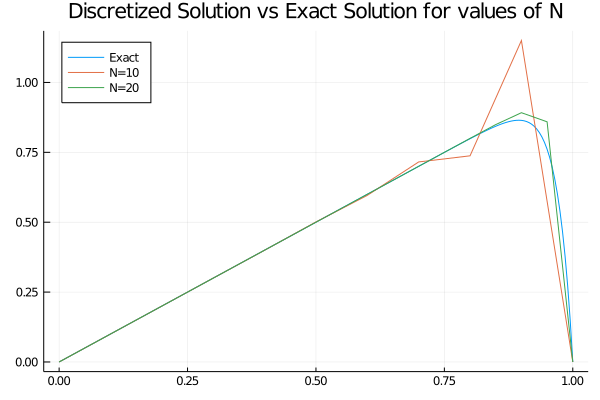

In [34]:
N = 10
sad10 = steady_advection_diffusion(N, 0.03)

xx = 0:1/200:1
sol = x -> x - (exp(x/0.03) - 1)/(exp(1/0.03) - 1)
plot(xx, [sol(x) for x = xx], label="Exact", title="Discretized Solution vs Exact Solution for values of N")

plot!([(1/N)*(i-1) for i = 1:N+1], vcat(vcat([0.0], sad10), [0.0]), label="N=10")

N = 20
sad20 = steady_advection_diffusion(N, 0.03)
plot!([(1/N)*(i-1) for i = 1:N+1], vcat(vcat([0.0], sad20), [0.0]), label="N=20", legend = :topleft)

<a name = 'q2c'></a>

(c) Produce a figure that provides a graphical confirmation of the convergence rate in $h$ **and** $\epsilon$ derived in Question 1. To get you started, there is some code provided that collects some suitable data to visualise. You can use this as is, or modify the code to collect different data. There are multiple ways to solve this question. 

(To understand the provided code you will need to solve Question 1 in detail.)

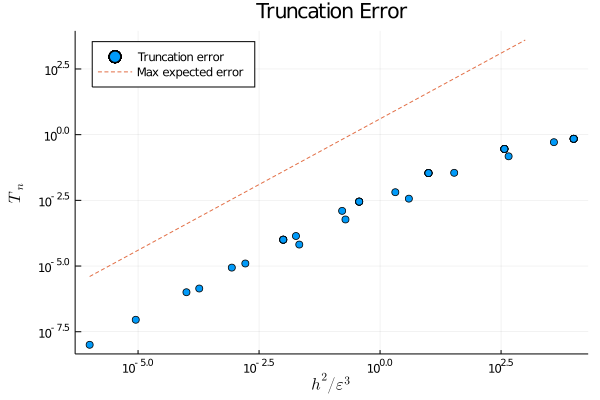

In [48]:
function get_err(N, epsn)
    u = x -> x - (exp(x/epsn) - 1) /  (exp(1/epsn) - 1)
    X = range(0, 1, length=N+1)[2:end-1]
    U = steady_advection_diffusion(N, epsn)
    return norm(U - u.(X), Inf)
end 

H = []
Epsn = [] 
Err = []
for epsn in [1.0, 0.3, 0.1, 0.03, 0.01]
    for tau in [10.0, 3.0, 1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001]
        h = tau * epsn^(-2/3)
        N = max(10, ceil(Int, 1/h))
        push!(H, 1/N)
        push!(Epsn, epsn)
        push!(Err, get_err(N, epsn))
    end
end

# Now use the error data collected in the above loop to 
# produce a convergence graph. E.g. you could produce 
# a scatter plot overlayed by the theoretical 
# prediction

plot(Epsn.^(-3).*H.^2, Err, xaxis=:log, seriestype = :scatter, yaxis=:log, legend=:topleft, label="Truncation error", title="Truncation Error")

xx = [10.0^(i) for i = -6:3]
plot!(xx, xx*4, line=:dash, label="Max expected error")
xlabel!(L"h^2/\epsilon^3")
ylabel!(L"T_n")

<a name = 'q2'></a>

### Question  3: Crank-Nicholson Method [5]

Consider the model diffusion equation 
$$\begin{aligned}
    u_t(t, x) &= u_{xx}(t, x) + f(t, x), \\ 
    u(0, x) &= u_0(x), \\ 
    u(t, 0) &= u(t, 1) = 0
\end{aligned}$$
for $x \in (0, 1)$ and $t \in (0, 1)$, $u_0 : [0, 1] \to \mathbb{R}$, $f : [0, 1] \times [0, 1] \to \mathbb{R}$.

Discretise it using second-order centered finite-differences in space and the Crank-Nicholson scheme (cf L06, L07) in time. Write down the full set of equations for the *interior* degrees of freedom, $U_n^m \approx u(m \tau, n h)$, $n = 1, \dots, N$, where $h$ is the spatial grid spacing and $\tau$ the time-step.



We know the Crank-Nicholson scheme for $u_t = g(t, u(t))$ is (`L06` and `L07`)

$$
    U^{m+1} = U^m + \frac{h}{2}\Big(g^m + g^{m+1}\Big)
$$

To apply this to our question, we need to formulate the finite difference for $u_{xx}(t,x) + f(t,x)$ s.t. we have a $g(t, u(t))$. We can apply the following difference scheme from `L09`

$$
    u_{xx} = \frac{u(x+h) - 2u(x) + u(x-h)}{h^2}
$$

Therefore we have 

$$
    g^m_n = \frac{U_{n+1}^m - 2U_{n}^m + U_{n-1}^m}{h^2} + f_{n}^{m}
$$

Where $g$ is used in the Crank-Nicholson scheme as follows

$$
    U_{n}^{m+1} = U_{n}^m + \frac{h}{2}\Big( g^m_n + g^{m+1}_n \Big)
$$



Solve **EITHER** Question 3T **OR** Question 3C

### <a name = 'q3a'></a>

### Question  3T: Crank-Nicholson Theory [12 + 8]

Following on from Question 2:

(a) Define the truncation error $T_n^m$; show that it satisfies 
$$
    |T_n^m| \leq C  \big( c_h h^2 + c_\tau \tau^2 \big)
$$
and specify $c_h, c_\tau$ in terms of the max-norm of certain derivatives of the exact solution $u$.

HINTs: 
* This calculation can get messy. Work out all details on paper before typesetting. Write out only  the most important steps in Latex. Make an effort to find an elegant path.
* re-use information from lectures as much as possible and effectively use the fact that $u$ satiesfies the PDE to make your life easier.
* When Taylor-expanding $(u^{m+1}-u^m) / \tau$, expand it in a way that is symmetric. For example, expand it twice: at $t_m$ and at $t_{m+1}$.

(b) Assuming that $\tau \leq h^2$ prove an error estimate for the max-norm error 
$$
    \| U - u \|_\infty := \max_{n, m} |U_n^m - u(\tau m, h n)|
$$
where $n = 0, \dots, N$ and $m = 0, \dots, M := \lceil 1/\tau \rceil$.

NOTE: The restriction $\tau \leq h^2$ leads to a simple proof, following the argument we used for the purely explicit and purely implicit discretisations. One can in fact prove stronger results without this restriction but they are more involved.

YOUR ANSWER HERE

<a name = 'q3ba'></a>

### Question 3C: Crank-Nicholson Implementation [10+10]

(a) Implement the Crank-Nicholson scheme from Q.2, following the example of the Implicit Euler scheme. I.e. the Crank-Nicholson method should return arrays of the same size and shape with each column containing the solution for that time-step. *Hint: how much of the implicit Euler code can you re-use?*

In [64]:
"""
N: number of spatial grid points
M: number of temporal grid points
u0 : initial condition (:: Function)
f : driving force (:: Function)
"""
function heat_implicit_euler(N, M, u0, f)
    h = 1/N
    X = range(0, 1, length = N+1)
    T = range(0, 1, length = M+1)
    U = zeros(N+1, M+1)
    U[:, 1] = u0.(X)
    D2 = spdiagm( -1 => N^2 * ones(N-2), 
                   0 => - 2*N^2 * ones(N-1), 
                   1 => N^2 * ones(N-2) )
    for m = 1:M
        F = f.(T[m+1], X[2:end-1])  # NOTE f is a function of t and x !
        U[2:end-1, m+1] = (I - h * D2) \ (U[2:end-1, m] + h * F)
    end
    return X, T, U
end

function heat_crank_nicholson(N, M, u0, f)
    h = 1/N
    X = range(0, 1, length = N+1)
    T = range(0, 1, length = M+1)
    U = zeros(N+1, M+1)
    U[:, 1] = u0.(X)
    D2 = spdiagm( -1 => -0.5*N * ones(N-2), 
                 0 => (1 + N) * ones(N-1), 
                 1 => -0.5*N * ones(N-2) )
    for m = 1:M
        b = [(1 - N)*U[i,m] + 0.5*N*U[i+1,m] + 0.5*N*U[i-1,m] + 0.5*h*(f(T[m], X[i]) + f(T[m+1], X[i])) for i=2:N]
        #F = f.(T[m+1], X[2:end-1])  # NOTE f is a function of t and x !
        U[2:end-1, m+1] = D2 \ b
    end
    return X, T, U
end

heat_crank_nicholson (generic function with 1 method)

<a name = 'q3bb'></a>

(b) Prescribe an exact solution $u(t, x) := \sin(\pi x) e^{-t}$ (note I've *deliberately* not chosen a solution of the homogeneous equation!) to choose $u_0$ and $f$ in order to numerically demonstrate the predicted convergence rate for implicit Euler and Crank-Nicholson methods. Visualize your results in a "presentation-quality" figure. Use $N = M$ for this test.

NOTEs: 
1. This strategy to check convergence and correctness of your code is called the **Method of Manufactured Solutions**.

2. I'm deliberately not giving you too much information here. The challenge (fun, I hope?) is to figure out how to write a convergence test more or less from scratch. This is a little bit of work but gets you out of doing the theory question. Be careful to correctly compute the force $f$. Be careful to use an appropriate range of $N=M$ values. Make the figure look nice.

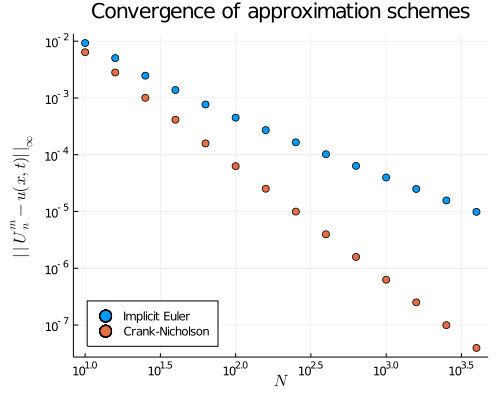

In [100]:
# Hint: use `heat_implicit_euler` and `heat_crank_nicholson` to produce the 
#       solutions and use the following to evaluate the exact solution on the grid

uex(t, x) = sin(pi * x) * exp(-t)
eval_uex(T, X) = [ uex(t, x) for x in X, t in T ]

f(t, x) = (pi^2 - 1)*exp(-t)*sin(pi * x)

pwrs = 1:0.2:3.6
Tn_ie = zeros(length(pwrs))
Tn_cn = zeros(length(pwrs))
for i = 1:length(pwrs)
    N = Int(floor(10.0^(pwrs[i])))
    Xie, Tie, Uie = heat_implicit_euler(N, N, (x) -> uex(0, x), f)
    Xcn, Tcn, Ucn = heat_crank_nicholson(N, N, (x) -> uex(0, x), f)
    Usl = eval_uex(Tie, Xie)
    Tn_ie[i] = maximum(abs.(Usl .- Uie))
    Tn_cn[i] = maximum(abs.(Usl .- Ucn))
end

Ns = 10.0.^pwrs
plot(Ns, Tn_ie, size = (500, 400), label = "Implicit Euler", legend = :bottomleft, seriestype = :scatter, xaxis=:log, yaxis=:log)
plot!(Ns, Tn_cn, seriestype = :scatter, label="Crank-Nicholson")
title!("Convergence of approximation schemes")
xlabel!(L"N")
ylabel!(L"\|\|U_n^m - u(x,t)\|\|_\infty")

<a name = 'q4'></a>

### Question 4: Advection with Boundary Condition  [5]

For $a > 0$ consider the advection equation with an inflow boundary at $x = 0$ and an outflow boundary at $x = 1$:

$$
\begin{aligned}
    u_t + a u_x &= 0,  \qquad x \in (0, 1), t \in (0, 1), \\ 
    u(0, x) &= u_0(x), \\ 
    u(t, 0) &= q(t).
\end{aligned}
$$

Adapt the upwind discretisation from the lecture for this equation and write down the full discrete system.

We can follow a very similar process to what was done in L10 to go from the general upwind scheme to something *almost* implementable.
$$
    \frac{U_n^{m+1} - U_n^m}{\tau} + a \frac{U_n^m - U_{n-1}^m}{h} = 0 \\ 
    \implies  \frac{U_n^{m+1} - U_n^m}{\tau} = - a \frac{U_n^m - U_{n-1}^m}{h} \\
    \implies U_n^{m+1} = \left(1 - \frac{a\tau}{h} \right) U_n^m + \frac{a\tau}{h} \,\, U_{n-1}^m
$$
To get to something that actually describes the full discretization though, we need to consider the boundary values.
$$
U_n^0 = u_o(nh) \quad\quad U_0^m = q(m\tau)
$$

Solve **EITHER** Question 4T **OR** Question 4C

<a name = 'q5a'></a>

### Question 4T: Advection Theory [7+8]

Following on from Q4:

(a) Define the truncation error $T_n^m$ and prove that 
$$
    |T_n^m| \leq C\big( c_h h + c_\tau \tau \big)
$$
specifying the constants $c_h, c_\tau$ in terms of the max-norm of derivatives of $u$.

(b) Follow the stability and converge proof in the lectures to deduce that 
$$
    \max_{n, m} |U_n^m - u(m\tau, nh)| \leq C(h + \tau),
$$
To prove this you will need to use the CFL condition. Clearly state it and point out where you are using it.

YOUR ANSWER HERE

<a name = 'q5b'></a>

### Question 4C: Advection Implementation [15]

Following on from Question 4:

Let $a = 1.1$. Consider an exact solution $u(t, x) = \sin(5*(x - a t))$ to the homogeneous solution. Determine the corresponding initial and boundary values $u_0(x)$ and $q(t)$. Then implement the finite-difference scheme from Q4, and animate the solution for $0 \leq x \leq 1, 0 \leq t \leq 5$, plotting both the exact and numerical solution. Choose a suitable resolution in both time and space.

HINT: Modify the codes from L10. Use the `@gif` macro.

┌ Info: Saved animation to 
│   fn = /Users/owensheekey/Documents/UBC/Math/Math 405/math405_2020W/assignments/A4/tmp.gif
└ @ Plots /Users/owensheekey/.julia/packages/Plots/shY1Z/src/animation.jl:104


Plots.AnimatedGif("/Users/owensheekey/Documents/UBC/Math/Math 405/math405_2020W/assignments/A4/tmp.gif")
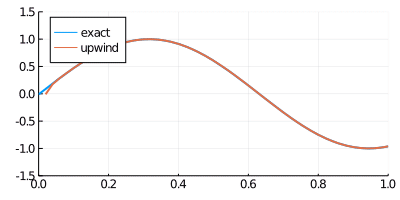

In [55]:
N = 50; 
h = 1/N; 
X = range(h, 1, length=N); 
xp = range(0, 1, length=1000)
Id = sparse(I, (N, N)); 
τ = 0.1 * h
a = 1.1
D⁻ = (Id - circshift(Id, 1)) / h
# Get rid of circular bc
D⁻[1, N] = 0

u0 = x -> sin(5*x)
q = t -> sin(-5*a*t)

U = u0.(X)
@gif for m = 1:500
    U[1] = q(m*τ)
    U -= τ * a * (D⁻ * U)
    plot(x -> sin(5*(x-a*m*τ)), 0, 1, lw=2, size = (400, 200), xlims = (0, 1), ylims = (-1.5, 1.5), label = "exact", legend = :topleft)
    plot!(X, U, lw=2, label = "upwind")
end

<a name = 'q6'></a>

### Question 5: Review Fourier Analysis [5+5+5]

We consider sequences $(U_n)_{n \in \mathbb{Z}}$ where we think of $U_n \approx u(h n)$. The semi-discrete Fourier transform is given by 
$$
    \hat{U}(k) := \sum_{n \in \mathbb{Z}} U_n e^{i k h n}, \qquad k \in (-\pi/h, \pi/h].
$$
We can think of the mapping $U \mapsto \hat{U}$ as a coordinate transformation. A (homogeneous) finite-difference scheme in terms of $U$ can be rewritten in terms of $\hat{U}$ and becomes *diagonal*. In preparation, we now transform three finite-difference operators into reciprocal space:

**Note:** The semi-discrete Fourier transform is more commonly defined as $\hat{U}(k) := \sum_{n \in \mathbb{Z}} U_n e^{-i k h n}.$ Since the choice of sign is a bit arbitrary and I used the $e^{i k h n}$ definition in the lectures, I am sticking with it for the assignment as well. But please be aware that most references you look at will use the $e^{- i k h n}$ definition.

(a) Let $V_n := U_n - U_{n-1}$; prove that 
$$
    \hat{V}(k) = (1 - e^{ikh}) \hat{U}(k)
$$

(b) Let $V_n := U_{n+1} - U_{n-1}$; prove that 
$$
    \hat{V}(k) = 2i \sin(kh) \hat{U}(k)
$$

(c) Let $V_n := U_{n+1} - 2 U_n + U_{n-1}$; prove that 
$$
    \hat{V}(k) = - 4 \sin^2(kh/2) \hat{U}(k).
$$


(a) We can first note that
$$
    \hat V(k) = \sum_{n \in \mathbb{Z}} (U_n - U_{n-1}) \,  e^{i k h n}
$$
This can be thought of as two sums, one is by definition the same as $\hat U(k)$
$$\begin{align}
     \hat V(k) &= \sum_{n \in \mathbb{Z}} U_n \,  e^{i k h n} - \sum_{n \in \mathbb{Z}} U_{n-1} \,  e^{i k h n} \\
     &= \hat U(k) -  \sum_{n \in \mathbb{Z}} U_{n-1} \,  e^{i k h n}
\end{align}$$
If we let $m=n-1 \implies n = m+1$
$$\begin{align}
    \sum_{n \in \mathbb{Z}} U_{n-1} \,  e^{i k h n} &= \sum_{m \in \mathbb{Z}} U_{m} \,  e^{i k h (m+1)} \\
    &= e^{i k h}\,\,\sum_{m \in \mathbb{Z}} U_{m} \,  e^{i k h m} \\
    &= e^{i k h} \hat U(k)
\end{align}$$
Therefore, overall we have 
$$
    \hat V(k) = \hat U(k) -  e^{i k h} \hat U(k) = \left( 1 - e^{i k h} \right)\hat U(k) \quad\quad \blacksquare
$$

(b) A similar process can be followed here 
$$\begin{align}
    \hat V(k) &= \sum_{n \in \mathbb{Z}} (U_{n+1} - U_{n-1}) \,  e^{i k h n} \\
    &= \sum_{n \in \mathbb{Z}} U_{n+1} \,  e^{i k h n} - \sum_{n \in \mathbb{Z}} U_{n-1} \,  e^{i k h n} \\
\end{align}$$
We already know the value of the $U_{n-1}$ sum from (a) so we need only work out the $U_{n+1}$ sum. 

Let  $m=n+1 \implies n = m-1$
$$\begin{align}
    \sum_{n \in \mathbb{Z}} U_{n+1} \,  e^{i k h n} &= \sum_{m \in \mathbb{Z}} U_{m} \,  e^{i k h (m-1)} \\
    &= e^{-i k h}\,\,\sum_{m \in \mathbb{Z}} U_{m} \,  e^{i k h m} \\
    &= e^{-i k h} \hat U(k)
\end{align}$$
Substitute everything in 
$$\begin{align}
    \hat V(k) &= \sum_{n \in \mathbb{Z}} U_{n+1} \,  e^{i k h n} - \sum_{n \in \mathbb{Z}} U_{n-1} \,  e^{i k h n} \\
    &= \left( e^{-i k h} - e^{i k h} \right) \hat U(k)
\end{align}$$
Note that $e^{ix} = \cos(x) + i\sin(x)$
$$\begin{align}
    \hat V(k) &= \left( \cos(kh) - i\sin(kh) - (\cos(kh) + i\sin(kh)) \right) \hat U(k) \\
    &= -2i\sin(kh) \,\, \hat U(k) \quad\quad \blacksquare
\end{align}$$
(c) Once again, a similar process
$$\begin{align}
    \hat V(k) &= \sum_{n \in \mathbb{Z}} (U_{n+1} - 2U_{n} + U_{n-1}) \,  e^{i k h n} \\
    &= \sum_{n \in \mathbb{Z}} U_{n+1} \,  e^{i k h n} - 2 \sum_{n \in \mathbb{Z}} U_{n} \,  e^{i k h n}  \sum_{n \in \mathbb{Z}} U_{n-1} \,  e^{i k h n} \\
\end{align}$$
But we already know all these sums! So we can simplify to
$$\begin{align}
    \hat V(k) &= \left( e^{-i k h} - 2 +  e^{i k h} \right) \hat U(k) \\
    &= \left( \cos(kh) - i\sin(kh) - 2 + \cos(kh) + i\sin(kh) \right) \hat U(k) \\
    &= \left( 2\cos(kh) - 2  \right) \hat U(k) \\
\end{align}$$
We can apply the trig identity $\cos(kh) - 1 = -2\sin^2\left(\frac{kh}{2}\right)$
$$
    \hat V(k) = -4\sin^2\left(\frac{kh}{2}\right)\hat U(k) \quad\quad \blacksquare
$$


<a name = 'q7'></a>

### Question 6: Von Neuman Stability Analysis [8+7] 

All finite-difference discretisations of various advection-diffusion systems we have considered so far can be written in the form 
$$
    [A U^{m+1}]_n = [B U^m]_n,
$$
where $A, B$ are finite-difference operators. By writing $\widehat{A U}(k) =
\hat{a}(k) \hat{U}(k)$ we obtain 
$$
    \hat{a}(k) \hat{U}^{m+1}(k) = \hat{b}(k) \hat{U}^m(k), 
$$
<!-- or 
$$
    \hat{U}^{m+1}(k) = \frac{\hat{b}(k)}{\hat{a}(k)} \hat{U}^m(k), 
$$ -->
Thus, we obtain the stability estimate 
$$
    \| \hat{U}^{m+1} \|_{2} \leq \| \hat{b}/\hat{a} \|_\infty \| \hat{U}^m \|_{2},
$$
and using the Plancherel theorem, 
$$
    \| U^{m+1} \|_{2} \leq \| \hat{b}/\hat{a} \|_\infty \| U^m \|_{2}.
$$
A method is called *von Neumann stable* if $\| \hat{b}/\hat{a} \|_\infty \leq 1$. It is unconditionally stable, if there are no restrictions on the step size. In the following we look at two concrete examples. 

HINT: Use the results of Question 5!

(a) Crank-Nicholson Scheme: show that the Crank-Nicholson method from Question 2 is unconditionally von Neumann stable.

(b) Consider the centered finite difference approximation of the advection equation $u_t + a u_x = 0$, 
$$
    \frac{U^{m+1}_n - U^m_n}{\tau} + a \frac{U^m_{n+1} - U^m_{n-1}}{2h} = 0, 
    \qquad n \in \mathbb{Z}, m = 0, 1, \dots, M-1,
$$
Prove that, given $h$, there is no choice of $\tau$ for which this scheme is von Neumann stable.


(a) We have
$$
    U_{n}^{m+1} + \frac{2U_{n}^{m+1} - U_{n+1}^{m+1} - U_{n-1}^{m+1}}{2h} = U_{n}^{m} + \frac{-2U_{n}^{m} + U_{n+1}^{m} + U_{n-1}^{m}}{2h}
$$
Following a similar process to the questions in `(5)` we can note that this simplifies to (I am heavily using `5c`)
$$
    \hat U^{m+1} \left( 1 - (-1/2h)(-4\sin^2\left(\frac{kh}{2}\right) \right) = 
    \hat U^{m}   \left( 1 + (1/2h)(-4\sin^2\left(\frac{kh}{2}\right) \right)
$$
Thus, we end up with 
$$
    \frac{\hat{b}(k)}{\hat{a}(k)} = \frac{1 - \frac{2}{h}\,\sin^2\left(\frac{kh}{2}\right)}{1 + \frac{2}{h}\,\sin^2\left(\frac{kh}{2}\right)}
$$
It is not so hard to see that, because $\sin^2$ is strictly positive, 
$$
    \| \hat{b}/\hat{a} \|_\infty < 1
$$

(b) We have 
$$
    \frac{U^{m+1}_n - U^m_n}{\tau} + a \frac{U^m_{n+1} - U^m_{n-1}}{2h} = 0
$$
We can simplify a bit 
$$
    U^{m+1}_n = U^{m}_n + \frac{a\tau}{2h} U^{m}_{n-1} + \frac{a\tau}{2h} U^{m}_{n+1}
$$
Applying von Neuman stability analysis
$$
    \hat U^{m+1}_n = \hat U^{m}_n \left( 1 + \frac{a\tau}{2h}(e^{ikh} - e^{-ikh}) \right)
$$
Finally, we end up with 
$$
    \hat U^{m+1}_n = \hat U^{m}_n \left( 1 + \frac{a\tau i \sin{kh}}{h} \right)
$$
And we have (for any value of $\tau$, $h$)
$$
    \| \hat{b}/\hat{a} \|_\infty =  1 + \frac{a\tau}{h} \| i\sin{kh} \|_\infty
$$
Therefore, for any value of $h$, we will end up with a positive non-zero contribution from the $\sin$ term for some values of $k$ regardless of how we pick any (non-zero) $\tau$ and, as such $\| \hat{b}/\hat{a} \|_\infty > 1 $.

<a name = 'bonus'></a>

### Bonus Question [no credit]

The von Neumann stability analysis gives a different notion of stability than the max-norm stability we used in the lectures so far. It therefore gives rise to a different error estimate. Concretely for the case of the Crank-Nicholson discretisation from Question 2, derive the natural error estimate arising from this alternative stability analysis and show that - unlike in Q.3 - it is *not conditional* on a step-size restriction.

Note that the numerical tests of Q3b should already be enough to confirm the correctness of your analysis in this question.

YOUR ANSWER HERE

In [73]:
N = 10
temp = spdiagm( -1 => 0.5*N * ones(N-2), 
                 0 => - N * ones(N-1), 
                 1 => 0.5*N * ones(N-2) )
Matrix(temp)
maximum(abs.(temp))

10.0